## Extract

In [1]:
import pandas as pd

In [2]:
# Extract projects
PROJECTS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(PROJECTS_URL)
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


In [3]:
TAGS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags = pd.read_csv(TAGS_URL)
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


## Transform

In [4]:
# join projects and tags
df = pd.merge(projects, tags, on='id')
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [5]:
df = df[df.tag.notnull()] # remove proejcts with no tag

## Load

In [6]:
df.to_csv("labeled_projects.csv", index=False)

## EDA

In [7]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

## Tag distribution

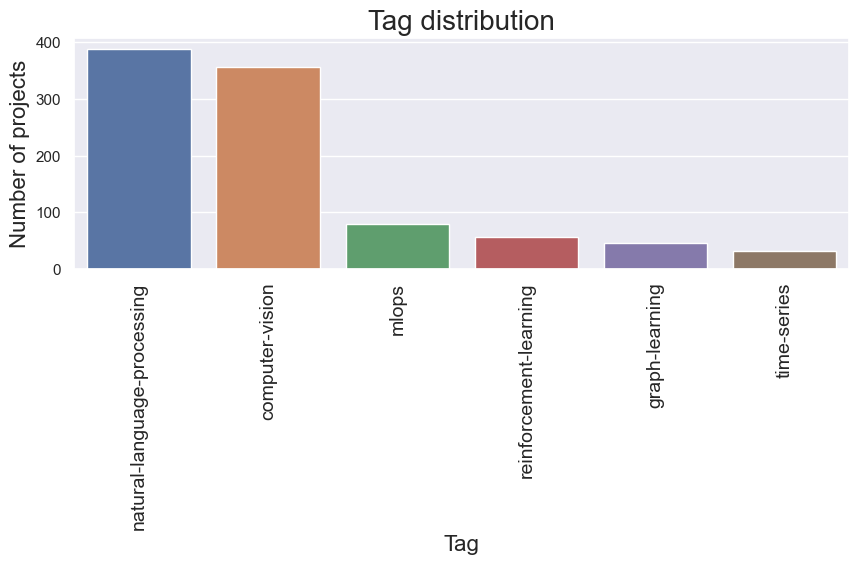

In [8]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [9]:
# Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

### Preprocessing

#### Feature Engineering

In [10]:
df["text"] = df.title + " " + df.description

### Cleaning

In [11]:
!pip install nltk==3.7 -q

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [13]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hedronstone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower:
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text


In [15]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Replace Labels

In [16]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [17]:
# Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

['reinforcement-learning', 'time-series']

In [18]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,reinforcement-learning,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,reinforcement-learning,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,time-series,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,reinforcement-learning,curriculum reinforcement learning curriculum l...


In [19]:
# Replace this tag with "other"
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

,id,created_on,title,description,tag,text
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other,awesome monte carlo tree search curated list m...
37,121,2020-03-24 04:56:38,Deep Reinforcement Learning in TensorFlow2,deep-rl-tf2 is a repository that implements a ...,other,deep reinforcement learning tensorflow2 deep r...
67,218,2020-04-06 11:29:57,Distributional RL using TensorFlow2,🐳 Implementation of various Distributional Rei...,other,distributional rl using tensorflow2 implementa...
74,239,2020-04-06 18:39:48,Prophet: Forecasting At Scale,Tool for producing high quality forecasts for ...,other,prophet forecasting scale tool producing high ...
95,277,2020-04-07 00:30:33,Curriculum for Reinforcement Learning,Curriculum learning applied to reinforcement l...,other,curriculum reinforcement learning curriculum l...


In [20]:
# Minimum frequency required for a tag
min_freq = 75
tags = Counter(df.tag.values)

In [21]:
def filter(tag, include=[]):
    """Determine if a given tag is to be included."""
    if tag not in include:
        tag = None
    return tag

In [22]:
# Filter tags that have fewer than <min_freq> occurrences
tags_above_freq = Counter(tag for tag in tags.elements()
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(filter, include=list(tags_above_freq.keys()))

In [23]:
# Fill None with other
df.tag = df.tag.fillna("other")

### Encoding

In [24]:
import numpy as np
import random

In [25]:
# Get data
X = df.text.to_numpy()
y = df.tag

In [26]:
class LabelEncoder(object):
    """Encode labels into unique indices"""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)


In [27]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [28]:
label_encoder.class_to_index

{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [29]:
label_encoder.index_to_class

{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [30]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])

array([0, 1, 1])

In [31]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(955,)


## Splitting

In [32]:
from sklearn.model_selection import train_test_split

# split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [33]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [34]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 668 (0.70)
remaining: 287 (0.30)


In [35]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [36]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [37]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [38]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,53,12,58,20
test,54,12,58,20


In [39]:
counts["val_counts"].keys()

dict_keys(['computer-vision', 'mlops', 'natural-language-processing', 'other'])

In [40]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [41]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

,computer-vision,mlops,natural-language-processing,other
train,249,55,272,92
val,247,56,270,93
test,252,56,270,93


In [42]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

0.9851056877051131

In [43]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

,text,tag
0,fast neural style pytorch implementation algor...,computer-vision
1,web mining information theory mining web playi...,natural-language-processing
2,learned looking 200 machine learning tools bet...,mlops
3,data quality key successful ml ops look ml ops...,mlops
4,serving pytorch models production amazon sagem...,mlops


## Augmentation

In [44]:
import nlpaug.augmenter.word as naw

In [45]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")
text = "Conditional image generation using Variational Autoencoders and GANs."

In [46]:
# Substitutions
substitution.augment(text)

'conditional data generation without variational autoencoders allow comparisons.'

In [47]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

In [48]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [49]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [50]:
print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [51]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")


True
True


In [52]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [53]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

<re.Match object; span=(10, 13), match='gan'>
None


In [54]:
from snorkel.augmentation import transformation_function

In [55]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [56]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases."""
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [57]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [58]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 668/668 [00:00<00:00, 746.78it/s]


,text,tag
0,fast neural style pytorch implementation algor...,computer-vision
1,web mining information theory mining web playi...,natural-language-processing
1,web mining information theory mining web playi...,natural-language-processing
1,web mining information theory mining web playi...,natural-language-processing
1,web mining information theory mining web playi...,natural-language-processing


## Modeling

In [59]:
import random

In [60]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [61]:
def preprocess(df, lower, stem, min_freq):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)  # clean text

    # Replace OOS tags with `other`
    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags_above_freq = Counter(tag for tag in tags.elements()
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df

In [62]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [63]:
num_samples = None
df = df.sample(frac=1).reset_index(drop=True)  # shuffle
df = df[: num_samples]  # None = all samples

### Random

In [64]:
from sklearn.metrics import precision_recall_fscore_support
import json

In [65]:
# Set up
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [66]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

<LabelEncoder(num_classes=4)>
['computer-vision', 'mlops', 'natural-language-processing', 'other']


In [67]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print (y_pred.shape)
print (y_pred[0:5])

(144,)
[2 2 1 3 3]


In [68]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall":metrics[1], "fscore": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.2844744487889649,
  "recall": 0.22916666666666666,
  "fscore": 0.24552884283001275
}


In [69]:
# class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [70]:
# Generate weighted random predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

In [71]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall":metrics[1], "fscore": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.3294211281499417,
  "recall": 0.3194444444444444,
  "fscore": 0.3239553132352485
}


### Rule-based

In [72]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [73]:
def get_tag(text, aliases_by_tag):
    """If a token matches an alias,
    then add the corresponding tag class."""
    for tag, aliases in aliases_by_tag.items():
        if replace_dash(tag) in text:
            return tag
        for alias in aliases:
            if alias in text:
                return tag
    return None


In [74]:
# Sample
text = "A pretrained model hub for popular nlp models."
get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

'natural-language-processing'

In [75]:
# Prediction
tags = []
for text in X_test:
    tag = get_tag(text, aliases_by_tag=aliases_by_tag)
    tags.append(tag)

In [76]:
# Encode labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

In [77]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.8611111111111112,
  "recall": 0.1597222222222222,
  "f1": 0.2600750175139683
}


In [78]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

None


### Vectorization

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

AttributeError: 'list' object has no attribute 'elements'

In [ ]:
# Saving raw X_test to compare with later
X_test_raw = X_test

In [ ]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train.shape)  # scipy.sparse.csr_matrix

In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

### Data Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

### Machine Learning

In [ ]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [ ]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="constant", eta0=1e-1, power_t=0.1,
    warm_start=True)

In [ ]:
# Train model
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

In [ ]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

In [ ]:
# Inference (with tokens similar to training data)
text = "Transfer learning with transformers for text classification."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

In [ ]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

In [ ]:
# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1
threshold

In [ ]:
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)

In [ ]:
def predict_tag(texts):
    y_prob = model.predict_proba(vectorizer.transform(texts))
    other_index = label_encoder.class_to_index["other"]
    y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
    return label_encoder.decode(y_pred)

In [ ]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
predict_tag(texts=[text])

In [ ]:
# Evaluate
other_index = label_encoder.class_to_index["other"]
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

## Evaluation

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Data to evaluate
other_index = label_encoder.class_to_index["other"]
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

In [ ]:
from collections import OrderedDict

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

### Manual Slices

In [ ]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)

@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

In [ ]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

In [ ]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

## Experiment Tracking

In [ ]:
!pip install mlflow==1.23.1 -q

In [ ]:
from argparse import Namespace
import mlflow
from pathlib import Path

In [ ]:
# Specify arguments
args = Namespace(
    lower=True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100
)

In [ ]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

In [ ]:
def train(args, df, trial=None):
    """Train model on data."""

    # Setup
    set_seeds()
    df = pd.read_csv("labeled_projects.csv")
    df = df.sample(frac=1).reset_index(drop=True)
    df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
    label_encoder = LabelEncoder().fit(df.tag)
    X_train, X_val, X_test, y_train, y_val, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))  # char n-grams
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Model
    model = SGDClassifier(
        loss="log", penalty="l2", alpha=args.alpha, max_iter=1,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t,
        warm_start=True)

    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

        # Log
        if not trial:
            mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        # Pruning (for optimization in next section)
        if trial:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Threshold
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
    args.threshold = np.quantile(
        [y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1

    # Evaluation
    other_index = label_encoder.class_to_index["other"]
    y_prob = model.predict_proba(X_test)
    y_pred = custom_predict(y_prob=y_prob, threshold=args.threshold, index=other_index)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print (json.dumps(performance, indent=2))

    return {
        "args": args,
        "label_encoder": label_encoder,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

In [ ]:
import joblib
import tempfile

In [ ]:
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

In [ ]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)


In [ ]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))
